# Imports

In [1]:
import yfinance as yf
import pandas as pd

from fbprophet import Prophet

from fbprophet.plot import plot_plotly
import plotly.offline as py

from fbprophet.plot import add_changepoints_to_plot

## Functions

In [2]:
# Get data from yfinance
def get_historical_yfinance(tickers):
    # Select requested tickers
    tickers = yf.Tickers(" ".join(tickers.keys()))
    # Return dataframe for all tickers
    return tickers.history(period="1mo", interval="1d", start=None, end=None, actions=True, rounding=True)

# Add extra info
def set_change_label(x):
    if x > 0:
        return 1
    else:
        return 0

def add_historical_extra_info(df):
    for ticker in my_tickers.keys():
        df['Change', ticker] = df['Close', ticker].diff()
        df['Change_Percent', ticker] = df['Close', ticker].div(df['Close', ticker].shift(1))*100-100
        df['Change_Label', ticker] = df['Change', ticker].apply(set_change_label)
    return df

# Plot one ticker
def plot_one_ticker(df, stock_label):
    hist_one = hist.iloc[:, hist.columns.get_level_values(1)==stock_label]
    #Delete level 1 column labels
    hist_one = hist_one.T.reset_index(level=1, drop=True).T
    display(hist_one.tail())
    display(hist_one['Change_Percent'].plot(figsize=(15,6)))
    #Extra info
#     print("Change Mean:", hist_one['Change'].mean())
#     print("Change Sum:", hist_one['Change'].sum())
#     print("Change Percent Mean:", hist_one['Change_Percent'].mean())
#     print("Change Label:", hist_one['Change_Label'].mean())
    
# Prepare dataset for Prophet
def prepare_dataset_prophet(df, ticker, column, regressors=False):
    # column = [Close, Dividends, High, Low, Open, Stock Splits, Volume, Change, Change_Percent, Change_Label]
    hist = pd.DataFrame({'ds': df.index, 'y': df[column, ticker]})
    if regressors:
        for reg in regressors:
            hist[reg] = df[reg, ticker]
    return hist

# Make Prophet model
def make_prophet_model(df, regressors=False):
    model = Prophet(growth='linear', ## growth = ['linear', 'logistic'] # Type of regression
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=False, 
                    seasonality_mode='additive', ## seasonality_mode=['additive', multiplicative']
                    #mcmc_samples=300, ## mcmc_samples = 0 # Uncertainly seasonality
                    #interval_width = 0.8, ## Size of yhat upper and lower
                   )
    if regressors:
        for reg in regressors:
            model.add_regressor(reg)
    #model.add_country_holidays(country_name='US')
    model.fit(df)
    return model

# Forecast the future
def forecast_prophet(model, days, include_history, regressors_df=False):
    if not isinstance(regressors_df, pd.DataFrame):
        future = model.make_future_dataframe(periods=days, freq='D', include_history=include_history)
        future = future[future.ds.dt.dayofweek<=4] # Take out Sat and Sun
    if isinstance(regressors_df, pd.DataFrame):
        future = regressors_df
    forecast = model.predict(future)

    return forecast

# Plot forecast
def plot_forecast(model, forecast):
    fig1 = model.plot(forecast) # .tail(days_to_predict-weekend_days)
    a = add_changepoints_to_plot(fig1.gca(), model, forecast) # Add changepoints
    fig2 = model.plot_components(forecast)

## Variables

In [3]:
my_tickers = {'ATVI': 'Activision',
              'ADS': 'Adidas',
              'GOOG': 'Alphabet',
              'MSFT': 'Microsoft',
              'AMZN': 'Amazon.com',
              'TEF': 'Telefonica',
              'CHFS': 'CHF_Solutions',
              'ASTC': 'Astrotech'
              }

stock_label = 'TEF'

predict_column = 'Change_Percent'

days_to_predict = 7

extra_regressors = ['Open', 'Close']

regressors_df = pd.DataFrame()

## Main

[*********************100%***********************]  8 of 8 completed


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


,ds,Open,Close
0,2020-03-30,3.849284,4.445726
1,2020-03-31,4.007153,4.728580
2,2020-04-01,4.072492,4.716401
3,2020-04-02,3.952799,4.634204
4,2020-04-03,3.903070,4.596994


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Close,Close_lower,Close_upper,Open,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-30,5.178089,3.503383,12.521579,5.178089,5.178089,-13.508423,-13.508423,-13.508423,23.456144,...,9.947721,9.947721,9.947721,-7.070428,-7.070428,-7.070428,0.0,0.0,0.0,8.055381
1,2020-03-31,5.474735,16.742862,25.436299,5.474735,5.474735,-6.048168,-6.048168,-6.048168,20.072559,...,14.024392,14.024392,14.024392,1.546208,1.546208,1.546208,0.0,0.0,0.0,21.045335
2,2020-04-01,5.771381,11.050557,19.949109,5.771381,5.771381,-6.369386,-6.369386,-6.369386,18.672162,...,12.302776,12.302776,12.302776,-2.540349,-2.540349,-2.540349,0.0,0.0,0.0,15.533808
3,2020-04-02,6.068027,11.903102,20.508685,6.068027,6.068027,-8.537343,-8.537343,-8.537343,21.237523,...,12.700181,12.700181,12.700181,-2.523418,-2.523418,-2.523418,0.0,0.0,0.0,16.244790
4,2020-04-03,6.364673,13.858873,22.904554,6.364673,6.364673,-9.518736,-9.518736,-9.518736,22.303362,...,12.784626,12.784626,12.784626,-0.685129,-0.685129,-0.685129,0.0,0.0,0.0,18.464170


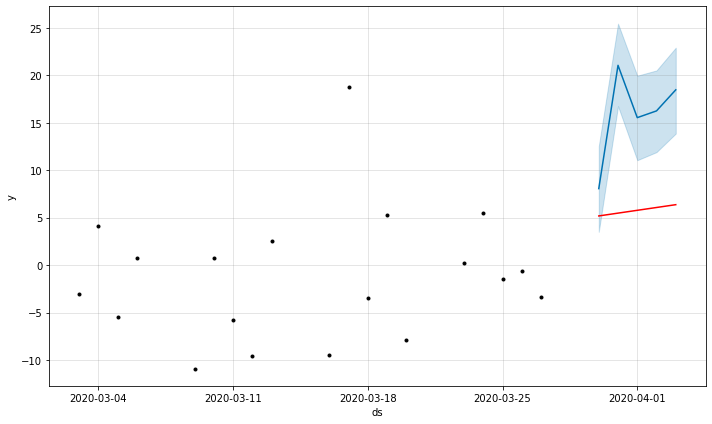

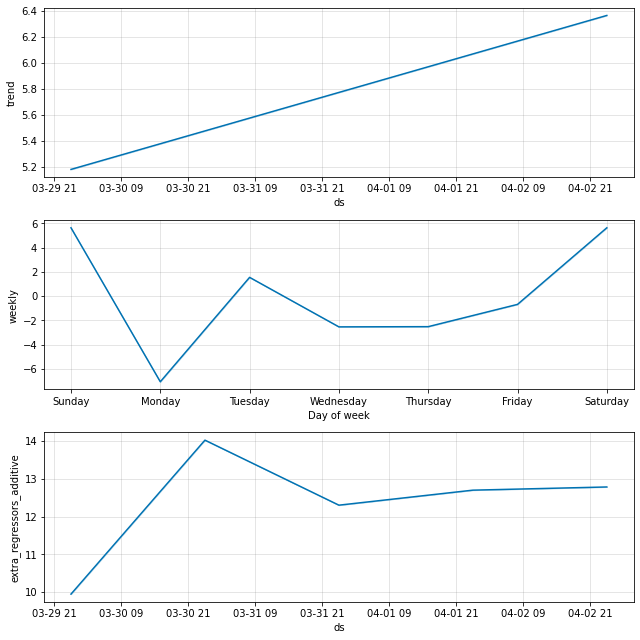

In [4]:
"""Get data from yfinance"""
hist = get_historical_yfinance(tickers=my_tickers)
"""Add extra info"""
hist = add_historical_extra_info(df=hist)
"""Plot one ticker"""
#plot_one_ticker(df=hist, stock_label=stock_label)


"""Add regressors"""
for reg in extra_regressors:
    """Prepare dataset for Prophet"""
    hist_one_prophet = prepare_dataset_prophet(df=hist, ticker=stock_label, column=reg, regressors=False)
    """Make Prophet model"""
    model = make_prophet_model(df=hist_one_prophet, regressors=False)
    """Forecast the future"""
    forecast = forecast_prophet(model=model, days=days_to_predict, include_history=False)
    if not 'ds' in regressors_df.columns:
        regressors_df['ds'] = forecast.ds
    regressors_df[reg] = forecast.yhat

display(regressors_df)


"""Prepare dataset for Prophet"""
hist_one_prophet = prepare_dataset_prophet(df=hist, ticker=stock_label, column=predict_column, regressors=extra_regressors)
"""Make Prophet model"""
model = make_prophet_model(df=hist_one_prophet, regressors=extra_regressors)
"""Forecast the future"""
forecast = forecast_prophet(model=model, days=days_to_predict, include_history=True, regressors_df=regressors_df)
display(forecast.tail())
"""Plot forecast"""
plot_forecast(model=model, forecast=forecast)